# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: Proyecto Integrador**

### Tecnológico de Monterrey

### Prof Dra. Grettel Barceló Alonso y Dr. Luis Eduardo Falcón Morales

## Avance III de Proyecto

## Modelo Base

## Integrantes del Equipo:
### - Erika Cardona Rojas            A01749170
### - Miriam Bönsch                  A01330346
### - Mardonio Manuel Román Ramírez  A01795265

In [35]:
# Librerias
import pandas as pd
import yaml
import numpy as np

# Cargando Yaml
with open("../config.yaml", "r", encoding="utf-8") as file:
    config = yaml.safe_load(file)

# Importando modulos
import sys
from pathlib import Path

from sklearn.metrics import mean_squared_error, r2_score

parent_folder = str(Path.cwd().parent)
if parent_folder not in sys.path:
    sys.path.append(parent_folder)

from src import filtering_vars as fv
from src import RFECV as fs
from src import regressions as r

In [36]:
# Cargando Base de Datos
df = pd.read_csv(r"../Data/DF_Final_No_Filtered.csv")

# Filtrado De Variables

Dada nuestra previa entrega, se ha discutido con los expertos la viabilidad de eliminación de las variables propuestas.

A continuación se aplicará la eliminación correspondiente a su retroalimentación.

In [37]:
# Creando PAD_media a partir de PAD_izq y PAD_der
df['PAD_media'] = df[['PAD_izq', 'PAD_der']].mean(axis=1)

In [38]:
# Eliminando variables correlacionadas y con un varianza casi nula.

vars_delete = config['Filtrado_Variables']['Umbral_Varianza'] + config['Filtrado_Variables']['Correlacionadas']

vars_delete = list(set(vars_delete))

df = df.drop(vars_delete, axis='columns')
print(f"Dada nuestra conversación con nuestros compañeros de Barcelona, se eliminarán {len(vars_delete)} variables.")

Dada nuestra conversación con nuestros compañeros de Barcelona, se eliminarán 86 variables.


# Reestructura De Datos

Los datos se encuentran repitiendo a cada sujeto 4 veces. Pues cada registro se divide en `Treatment` (Intervención y Control) y `Time` (Pre y Post).

Nos interesa conocer los efectos del experimento en el periodo Post de la Intervención con tomate.

Por lo que se estructurará la base de datos, de manera que nos funcione así.

En este modelo, predeciremos el efecto en el tratamiento (delta bdnf), así mismo aprovecharemos la manipulación de los datos para generar otra variable objetivo, que sería el
efecto neto (delta BDNF Intervención - delta BDNF Control).

In [39]:
# Generando deltas.

# Pivoteando para tener pre y post como columnas.
df_deltas = df.pivot(index=['id','Treatment'], columns='Time', values='bdnf').reset_index()
# Calculando delta por tratamiento
df_deltas['delta_bdnf'] = df_deltas['Post'] - df_deltas['Pre']

In [40]:
# Primer variable: Delta en Periodo de Tratamiento.
df_delta_I = df_deltas[df_deltas['Treatment'] == 'Intervencion']
df_delta_I = df_delta_I[['id','delta_bdnf']].rename(columns={'delta_bdnf':'delta_bdnf_Int'})

In [41]:
# Generando efecto neto.
df_delta_N = df_deltas.pivot(index=['id'], columns='Treatment', values='delta_bdnf').reset_index()
# Calculando delta por tratamiento
df_delta_N['delta_bdnf_Neto'] = df_delta_N['Intervencion'] - df_delta_N['Control']

df_delta_N = df_delta_N[['id','delta_bdnf_Neto']]

deltas = df_delta_N.merge(df_delta_I)

del df_delta_N,df_delta_I,df_deltas

Generando Dataset para predecir con el estado basal del periodo intervención.

Se agregarán variables objetivos: 

    - delta bdnf en periodo de intervención
    - delta bdnf neto : delta intervención - delta control

In [42]:
# Generando Dataset.
df_pred = df[(df['Treatment'] == 'Intervencion') & (df['Time'] == 'Pre')].reset_index(drop=True)

# Agregando Variables Objetivo
df_pred = df_pred.merge(deltas)
# Eliminando columnas no deseadas en entrenamiento
df_pred = df_pred.drop(columns= config['Tratamiento_Variables']['Objetivos'] + ['id', 'grupo', 'Treatment', 'Time'])

# Para este modelo, eliminaremos la del efecto neto, únicamente modelaremos el efecto en intervención
del df_pred['delta_bdnf_Neto']

### Antes hacer la eliminación recursiva, agruparemos unas variables que significan lo mismo. (discutido con nuestros compañeros de barcelona)

In [43]:
df_pred['ffq_azucares_grouped'] = df_pred['ffq_mermeladas'] + df_pred['ffq_mieles'] + df_pred['ffq_azuc'] + df_pred['ffq_azucares']

df_pred['ffq_especias_grouped'] = df_pred['ffq_perejil'] + df_pred['ffq_picante']

df_pred['ffq_botanas_grouped'] = df_pred['ffq_p_fritascom'] + df_pred['ffq_snack']

df_pred['ffq_cereales_grouped'] = df_pred['ffq_cerealdes'] + df_pred['ffq_tortitas']

df_pred['ffq_jugos_grouped'] = df_pred['ffq_z_natural'] + df_pred['ffq_z_frutasnat'] + df_pred['ffq_z_botella']

df_pred['ffq_vino_tinto_grouped'] = df_pred['ffq_v_tintojov'] + df_pred['ffq_v_tintoañej']

df_pred['ffq_otros_vinos_grouped'] = df_pred['ffq_v_blanco'] + df_pred['ffq_v_rosado'] + df_pred['ffq_cavas']

df_pred['ffq_cerveza_grouped'] = df_pred['ffq_cervezas'] + df_pred['ffq_cerveza_sin']

df_pred['ffq_licores_grouped'] = df_pred['ffq_licores'] + df_pred['ffq_whisky']

df_pred['ffq_postres_grouped'] = (
    df_pred['ffq_g_maria'] + df_pred['ffq_g_integral'] + df_pred['ffq_g_sinazucar'] +
    df_pred['ffq_g_choco'] + df_pred['ffq_bizcocho'] + df_pred['ffq_croissant'] +
    df_pred['ffq_natilla'] + df_pred['ffq_pastel'] + df_pred['ffq_churro'] +
     df_pred['ffq_turrones'] + df_pred['ffq_chocolates'] + df_pred['ffq_cacao']
)

# Eliminando las variables que componen los grupos
df_pred = df_pred.drop(
    columns=[
        'ffq_mermeladas', 'ffq_mieles', 'ffq_azuc', 'ffq_azucares', 'ffq_perejil', 'ffq_picante', 'ffq_cerealdes', 'ffq_tortitas',
        'ffq_z_natural', 'ffq_z_frutasnat', 'ffq_z_botella', 'ffq_v_tintojov', 'ffq_v_tintoañej', 'ffq_v_blanco',
        'ffq_v_rosado', 'ffq_cavas', 'ffq_cervezas', 'ffq_cerveza_sin', 'ffq_licores', 'ffq_whisky',
        'ffq_g_maria', 'ffq_g_integral', 'ffq_g_sinazucar','ffq_g_choco', 'ffq_bizcocho', 'ffq_croissant','ffq_natilla',
        'ffq_pastel', 'ffq_churro','ffq_turrones', 'ffq_chocolates', 'ffq_cacao'
    ]
)

In [48]:
df_pred.to_excel(r'../Data/DF_Pred_4.xlsx', index=False)

# Eliminación Recursiva de Características con Validación Cruzada (RFECV)

### Justificación Metodológica: Selección de Variables (RFECV)

**Contexto:** El dataset MITOS presenta alta dimensionalidad ($p=450$) frente a un tamaño muestral limitado. Generar interacciones explícitas crearía $>100,000$ variables, garantizando **sobreajuste (overfitting)** y pérdida de interpretabilidad clínica.

**Estrategia:** Implementamos **RFECV (Recursive Feature Elimination with Cross-Validation)** utilizando **XGBoost Regressor** como estimador base.

**Ventajas Técnicas:**
1.  **Interacciones Implícitas:** A diferencia de la regresión lineal, XGBoost captura relaciones no lineales e interacciones complejas internamente (profundidad de árboles) sin inflar el dataset.
2.  **Robustez (K-Fold CV):** La importancia de cada variable se valida en múltiples particiones de datos, evitando sesgos por muestras específicas.
3.  **Parsimonia Objetiva:** El algoritmo selecciona matemáticamente el subconjunto mínimo de biomarcadores originales que maximiza la generalización ($R^2$), preservando la **explicabilidad biológica** del cambio en BDNF.

> ## Ajustando RFECV con XGBoost

 Analizando 422 variables.


c:\Users\mardo\Documents\Repositories\Proyecto-Polifenoles\.venv\Lib\site-packages\sklearn\feature_selection\_rfe.py:300: UserWarning: Found n_features_to_select=np.int64(426) > n_features=422. There will be no feature selection and all features will be kept.
  warnings.warn(
c:\Users\mardo\Documents\Repositories\Proyecto-Polifenoles\.venv\Lib\site-packages\sklearn\feature_selection\_rfe.py:300: UserWarning: Found n_features_to_select=np.int64(426) > n_features=422. There will be no feature selection and all features will be kept.
  warnings.warn(
c:\Users\mardo\Documents\Repositories\Proyecto-Polifenoles\.venv\Lib\site-packages\sklearn\feature_selection\_rfe.py:300: UserWarning: Found n_features_to_select=np.int64(426) > n_features=422. There will be no feature selection and all features will be kept.
  warnings.warn(
c:\Users\mardo\Documents\Repositories\Proyecto-Polifenoles\.venv\Lib\site-packages\sklearn\feature_selection\_rfe.py:300: UserWarning: Found n_features_to_select=np.int6

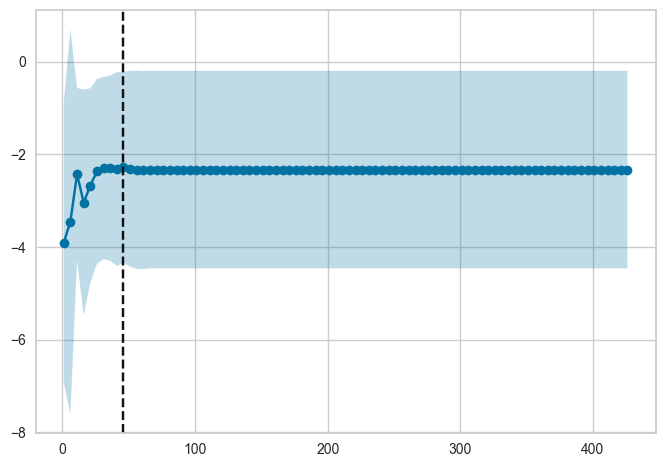

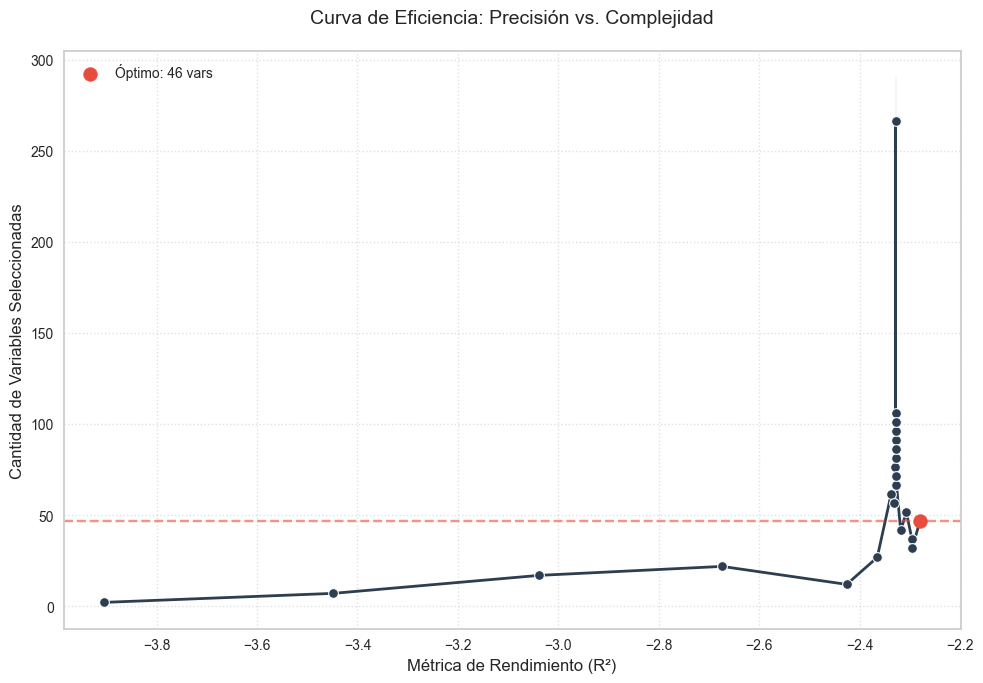

Proceso terminado en 610.77s
Resultado: Se eliminaron 376 variables.


In [21]:
# Creando Dataframe y serie
X = df_pred.drop(columns='delta_bdnf_Int')
y = df_pred.loc[:,'delta_bdnf_Int']

# Ejecutando la selección de variables

selected_features, df_ranking = fs.select_features_rfecv_xgboost(X, y, step=5, cv_splits=5)

In [22]:
# Guardando Dataframe
df_ranking.to_excel('../Entregables/UdeBarcelona/RFECV.xlsx', index= False)

> ## Ajustando RFECV con Lasso

Analizando 422 variables con Lasso (Penalización L1)...


c:\Users\mardo\Documents\Repositories\Proyecto-Polifenoles\.venv\Lib\site-packages\sklearn\feature_selection\_rfe.py:300: UserWarning: Found n_features_to_select=np.int64(424) > n_features=422. There will be no feature selection and all features will be kept.
  warnings.warn(
c:\Users\mardo\Documents\Repositories\Proyecto-Polifenoles\.venv\Lib\site-packages\sklearn\feature_selection\_rfe.py:300: UserWarning: Found n_features_to_select=np.int64(424) > n_features=422. There will be no feature selection and all features will be kept.
  warnings.warn(
c:\Users\mardo\Documents\Repositories\Proyecto-Polifenoles\.venv\Lib\site-packages\sklearn\feature_selection\_rfe.py:300: UserWarning: Found n_features_to_select=np.int64(424) > n_features=422. There will be no feature selection and all features will be kept.
  warnings.warn(
c:\Users\mardo\Documents\Repositories\Proyecto-Polifenoles\.venv\Lib\site-packages\sklearn\feature_selection\_rfe.py:300: UserWarning: Found n_features_to_select=np.int6

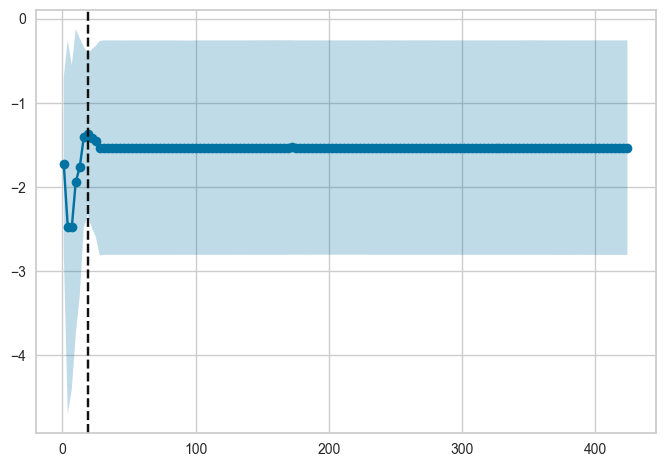

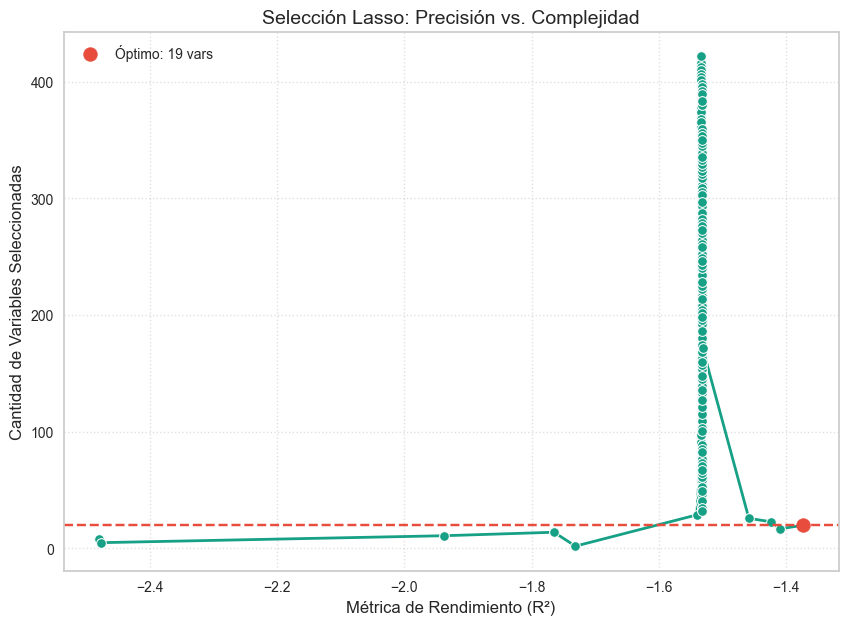

Proceso terminado en 72.73s
Resultado: Lasso seleccionó 19 variables.


In [23]:
# Ejecutando la selección de variables, aquí nos vamos de 3 por 3 (step = 3)

selected_features, df_ranking = fs.select_features_rfecv_lasso(X, y, step= 3)

In [24]:
# Guardando Dataframe
df_ranking.to_excel('../Entregables/UdeBarcelona/RFECV_Lasso.xlsx', index= False)

# Modelado

## Entrenamiento del Modelo Predictivo Final (Baseline)

Tras el proceso de selección de características mediante **RFECV**, hemos reducido el espacio dimensional de **444 a 101 variables**. Este subconjunto representa el "núcleo informativo" que maximiza el coeficiente de determinación ($R^2$) minimizando el ruido estructural.

### 📋 Configuración del Experimento
En esta etapa, procederemos a entrenar un modelo **XGBoost Regressor** bajo las siguientes premisas:

1.  **Modelo Base (Baseline):** Se utilizan hiperparámetros genéricos y balanceados. El objetivo es establecer un punto de referencia (benchmarking) antes de realizar una optimización fina (*Hyperparameter Tuning*).
2.  **Variables Seleccionadas:** El entrenamiento se restringe exclusivamente a las **101 variables** que obtuvieron un `Ranking == 1`, asegurando que el modelo sea más parsimonioso y eficiente.
3.  **Evaluación Robusta:** Se implementa una división de datos **80/20** para entrenamiento y prueba, permitiendo medir la capacidad de generalización del modelo en datos no observados.

### 📈 Métricas de Control
Para evaluar la calidad de la respuesta clínica predicha, analizaremos:
* **$R^2$ (R-Squared):** Varianza explicada por el modelo.
* **MAE & RMSE:** Magnitud del error en las unidades originales de la variable clínica.
* **MAPE:** Error porcentual para validar la precisión relativa del modelo.

> **Nota:** Este modelo servirá como base para futuras interpretaciones de impacto individual mediante valores SHAP.

## Variables Top Según XGBoost

In [25]:
df_ranking = pd.read_excel('../Entregables/UdeBarcelona/RFECV.xlsx')

selected_features = df_ranking.loc[df_ranking['Ranking'] == 1, 'Feature']

In [26]:
r.train_and_evaluate_xgboost(X, y, selected_features)

✅ Datos preparados: Train 31 | Test 11
Entrenando modelo final...

METRICAS DE DESEMPEÑO
R² Score:   -0.3735  (Proporción de varianza explicada)
MAE:        32.5938  (Error promedio en unidades reales)
RMSE:       59.5890  (Penaliza errores grandes)
MAPE:       118.13% (Error relativo porcentual)


(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=-1, num_parallel_tree=None, ...),
     licopeno  pgh_calidad_sueño  total_meds   ffq_vit_c  ffq_mayones  \
 25  0.124783                  1           0  184.535524     0.000000   
 13  0.138957                  1           0  241.350143    15.714286   
 8   0.143492            

El modelo es pésimo aún con únicamente 100 variables, intentaremos con un top 20 para ver si mejora.

In [27]:
r.train_and_evaluate_xgboost(X, y, df_ranking.iloc[:15, 0])

✅ Datos preparados: Train 31 | Test 11
Entrenando modelo final...

METRICAS DE DESEMPEÑO
R² Score:   -0.0895  (Proporción de varianza explicada)
MAE:        27.3281  (Error promedio en unidades reales)
RMSE:       53.0708  (Penaliza errores grandes)
MAPE:       81.81% (Error relativo porcentual)


(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=-1, num_parallel_tree=None, ...),
     licopeno  pgh_calidad_sueño  total_meds   ffq_vit_c  ffq_mayones  \
 25  0.124783                  1           0  184.535524     0.000000   
 13  0.138957                  1           0  241.350143    15.714286   
 8   0.143492            

> ## Haciendo las mismas pruebas de modelos base pero ahora con un Random Forest

In [28]:
r.train_and_evaluate_random_forest(X, y, selected_features)

✅ Datos preparados: Train 31 | Test 11
Entrenando Random Forest final...

METRICAS DE DESEMPEÑO (Random Forest)
R² Score:   0.0241  (Proporción de varianza explicada)
MAE:        27.6610  (Error promedio en unidades reales)
RMSE:       50.2286  (Penaliza errores grandes)
MAPE:       88.58% (Error relativo porcentual)


(RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=5, n_estimators=1000, n_jobs=-1,
                       random_state=42),
     licopeno  pgh_calidad_sueño  total_meds   ffq_vit_c  ffq_mayones  \
 25  0.124783                  1           0  184.535524     0.000000   
 13  0.138957                  1           0  241.350143    15.714286   
 8   0.143492                  1           3  144.175619     0.000000   
 26  0.324396                  1           2  128.697048     2.857143   
 4   0.256835                  2           0   57.947524     1.333333   
 39  0.120059                  1           0  140.299190     1.333333   
 19  0.117135                  1           1  157.025857     1.333333   
 29  0.149799                  0           0  181.290286     8.571429   
 30  0.274016                  2           2  153.048714     1.333333   
 6   0.384735                  0           0   96.701667     0.000000   
 27  

In [29]:
r.train_and_evaluate_xgboost(X, y, df_ranking.iloc[:15, 0])

✅ Datos preparados: Train 31 | Test 11
Entrenando modelo final...

METRICAS DE DESEMPEÑO
R² Score:   -0.0895  (Proporción de varianza explicada)
MAE:        27.3281  (Error promedio en unidades reales)
RMSE:       53.0708  (Penaliza errores grandes)
MAPE:       81.81% (Error relativo porcentual)


(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=-1, num_parallel_tree=None, ...),
     licopeno  pgh_calidad_sueño  total_meds   ffq_vit_c  ffq_mayones  \
 25  0.124783                  1           0  184.535524     0.000000   
 13  0.138957                  1           0  241.350143    15.714286   
 8   0.143492            

---
## Variables Top Según Lasso

In [30]:
df_ranking = pd.read_excel('../Entregables/UdeBarcelona/RFECV_Lasso.xlsx')

selected_features = df_ranking.loc[df_ranking['Ranking'] == 1, 'Feature']

In [31]:
r.train_and_evaluate_xgboost(X, y, selected_features)


✅ Datos preparados: Train 31 | Test 11
Entrenando modelo final...

METRICAS DE DESEMPEÑO
R² Score:   0.2024  (Proporción de varianza explicada)
MAE:        27.7690  (Error promedio en unidades reales)
RMSE:       45.4097  (Penaliza errores grandes)
MAPE:       141.65% (Error relativo porcentual)


(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=-1, num_parallel_tree=None, ...),
     fam_obesidad  pgh_5d  ffq_refrescsin  Palabras_moca  tom_sofrito  \
 25             0       0        0.000000             20           19   
 13             1       0       28.571429             31           19   
 8              0       0

In [32]:
r.train_and_evaluate_xgboost(X, y, df_ranking.iloc[:10, 0])

✅ Datos preparados: Train 31 | Test 11
Entrenando modelo final...

METRICAS DE DESEMPEÑO
R² Score:   0.1165  (Proporción de varianza explicada)
MAE:        25.4327  (Error promedio en unidades reales)
RMSE:       47.7918  (Penaliza errores grandes)
MAPE:       131.26% (Error relativo porcentual)


(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=-1, num_parallel_tree=None, ...),
     fam_obesidad  pgh_5d  ffq_refrescsin  Palabras_moca  tom_sofrito  \
 25             0       0        0.000000             20           19   
 13             1       0       28.571429             31           19   
 8              0       0

> ## Haciendo las mismas pruebas de modelos base pero ahora con un Random Forest

In [33]:
r.train_and_evaluate_random_forest(X, y, selected_features)

✅ Datos preparados: Train 31 | Test 11
Entrenando Random Forest final...

METRICAS DE DESEMPEÑO (Random Forest)
R² Score:   0.1254  (Proporción de varianza explicada)
MAE:        26.8897  (Error promedio en unidades reales)
RMSE:       47.5491  (Penaliza errores grandes)
MAPE:       106.83% (Error relativo porcentual)


(RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=5, n_estimators=1000, n_jobs=-1,
                       random_state=42),
     fam_obesidad  pgh_5d  ffq_refrescsin  Palabras_moca  tom_sofrito  \
 25             0       0        0.000000             20           19   
 13             1       0       28.571429             31           19   
 8              0       0        0.000000             17            8   
 26             1       0       13.333333             18           12   
 4              0       1      200.000000              6            0   
 39             0       0        0.000000             14            0   
 19             1       0        0.000000             18           42   
 29             1       0       85.714286             14           22   
 30             1       0       28.571429             20            1   
 6              0       0        0.000000             21            6   
 27  

Podemos ver que los resultados con las variables indicadas según la regresión Lasso son por mucho mejores, se evaluará y discutirá eso con los expertos para el entrenamiento de modelos más robustos con esas variables.

---
# A Continuación, se propone un segundo modelo base.

Estimamos el bdnf utilizando las dos mediciones basales (periodo control e intervención).
Este enfoque, predice el valor tal cual y no el efecto del tratamiento, resultará interesante optimizar y robustecer ambos.

In [34]:
# Visualizar count de periodo antes de transformación

df["Time"].value_counts()

Time
Pre     84
Post    84
Name: count, dtype: int64

In [ ]:
# Filtrar datos solo con periodo Pre

df_pre = df[df["Time"] == "Pre"].copy()

print("Dataset Periodo Pre:", df_pre.shape)
df_pre.head()

In [ ]:
# Confirmación de que ya no aparezca periodo Post

df_pre["Time"] if "periodo" in df_pre.columns else "Periodo eliminado correctamente", print("Filas Post restantes:", (df_pre == "Post").sum().sum())
df["Time"] = df["Time"].astype(str).str.strip().str.lower()

In [ ]:
df_pre = df[df["Time"] == "pre"].copy()
print(df_pre.shape)

# Random Forest - BDNF

In [ ]:
# Definir objetivo - BDNF

target = "bdnf"

y = df_pre[target]

print("Objetivo:", target)
print("Tamaño de y:", y.shape)

In [ ]:
# Definir predictores

X = df_pre.drop(columns=[target, "ID"], errors="ignore")

print("Tamaño de X:", X.shape)

In [ ]:
# Eliminar columnas no numéricas

X = X.select_dtypes(include=["int64", "float64"])

print("X solo numéricas:", X.shape)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Valores faltantes - no NaN

imputer = SimpleImputer(strategy="median")

X_imputed = imputer.fit_transform(X)

In [ ]:
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

print("NaNs restantes:", X_imputed.isna().sum().sum())

In [ ]:
# Split Train/Test

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y,
    test_size=0.15,
    random_state=42
)

print("Train:", X_train.shape)
print("Test:", X_test.shape)

In [ ]:
rf_bdnf = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

rf_bdnf.fit(X_train, y_train)

print("Modelo entrenado: Exitoso")

In [ ]:
y_pred = rf_bdnf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, y_pred)

print("Baseline Random Forest - BDNF (Pre)")
print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", r2)

In [ ]:
# Variables importantes

import numpy as np

importances = rf_bdnf.feature_importances_

feat_imp_bdnf = pd.DataFrame({
    "variable": X.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

feat_imp_bdnf.head(10)

In [ ]:
feat_imp_bdnf.to_excel("../entregables/UdeBarcelona/FeatureImportance_BDNF_Pre.xlsx", index=False)

print("Archivo guardado: FeatureImportance_BDNF_Pre.xlsx")

Se entrenó un modelo baseline mediante Random Forest Regressor utilizando únicamente observaciones del periodo Pre con el objetivo de explorar la capacidad predictiva inicial del conjunto de variables clínicas y de estilo de vida sobre los niveles de BDNF.

El modelo obtuvo un RMSE de 21.98 y un R² negativo (-0.32), lo que sugiere que, bajo las condiciones actuales, no se identifican patrones predictivos robustos. Este resultado es esperable debido al tamaño reducido de la muestra (n=84) en comparación con el elevado número de variables (p>500), así como a la alta variabilidad biológica inherente al biomarcador.

Por lo tanto, este baseline se considera un punto de referencia exploratorio más que un modelo final, alineado con el enfoque científico del proyecto.

# Random Forest - Delta

In [ ]:
delta_targets = [
    "delta_bdnf",
    "delta_d2_con_pd",
    "delta_d2_vt_pd",
    "delta_fn_nombre",
    "delta_fn_score",
    "delta_licopeno"
]

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
def baseline_rf(df, target):

    print("\n==============================")
    print("Baseline Random Forest para:", target)
    print("==============================")

    # Eliminar filas sin target
    df_model = df.dropna(subset=[target]).copy()

    # Definir y
    y = df_model[target]

    # Definir X (quitando target, ID y periodo)
    X = df_model.drop(columns=[target, "ID", "Time"], errors="ignore")

    # Quedarnos solo con numéricas
    X = X.select_dtypes(include=["int64", "float64"])

    print("Dataset:", X.shape)

    # Imputación
    imputer = SimpleImputer(strategy="median")
    X_imp = imputer.fit_transform(X)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_imp, y,
        test_size=0.2,
        random_state=42
    )

    # Modelo
    rf = RandomForestRegressor(
        n_estimators=300,
        random_state=42
    )

    rf.fit(X_train, y_train)

    # Predicción
    y_pred = rf.predict(X_test)

    # Métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("RMSE:", rmse)
    print("R2:", r2)

    # Feature importance
    feat_imp = pd.DataFrame({
        "variable": X.columns,
        "importance": rf.feature_importances_
    }).sort_values(by="importance", ascending=False)

    return feat_imp

In [ ]:
resultados_importancia = {}

for target in delta_targets:
    feat_imp = baseline_rf(df, target)
    resultados_importancia[target] = feat_imp

    # Guardar top 15 por variable
    feat_imp.head(15).to_excel(f"Top15_{target}.xlsx", index=False)

In [ ]:
summary = []

for target in delta_targets:

    df_model = df.dropna(subset=[target]).copy()
    y = df_model[target]

    X = df_model.drop(columns=[target, "ID", "periodo"], errors="ignore")
    X = X.select_dtypes(include=["int64", "float64"])

    imputer = SimpleImputer(strategy="median")
    X_imp = imputer.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_imp, y, test_size=0.2, random_state=42
    )

    rf = RandomForestRegressor(n_estimators=300, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    summary.append({
        "Target": target,
        "RMSE": rmse,
        "R2": r2,
        "N_samples": len(df_model)
    })

summary_df = pd.DataFrame(summary)
summary_df

In [ ]:
summary_df.to_excel("../Entregables/UdeBarcelona/Baseline_RF_Deltas_Resumen.xlsx", index=False)
print("Archivo guardado: Baseline_RF_Deltas_Resumen.xlsx")

In [ ]:
importances = rf.feature_importances_

feat_imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values("Importance", ascending=False)

feat_imp.head(10)